In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler, simple_filter_sched
from lsst.sims.featureScheduler.utils import standard_goals, generate_goal_map, Footprint, restore_scheduler
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (Greedy_survey, generate_dd_surveys,
                                                Blob_survey)
from lsst.sims.featureScheduler import sim_runner
import lsst.sims.featureScheduler.detailers as detailers

In [2]:
def gen_greedy_surveys(nside=32, nexp=1, exptime=30., filters=['r', 'i', 'z', 'y'],
                       camera_rot_limits=[-80., 80.],
                       shadow_minutes=60., max_alt=76., moon_distance=30., ignore_obs='DD',
                       m5_weight=3., footprint_weight=0.3, slewtime_weight=3.,
                       stayfilter_weight=3., footprints=None):
    """
    Make a quick set of greedy surveys

    This is a convienence function to generate a list of survey objects that can be used with
    lsst.sims.featureScheduler.schedulers.Core_scheduler.
    To ensure we are robust against changes in the sims_featureScheduler codebase, all kwargs are
    explicitly set.

    Parameters
    ----------
    nside : int (32)
        The HEALpix nside to use
    nexp : int (1)
        The number of exposures to use in a visit.
    exptime : float (30.)
        The exposure time to use per visit (seconds)
    filters : list of str (['r', 'i', 'z', 'y'])
        Which filters to generate surveys for.
    camera_rot_limits : list of float ([-80., 80.])
        The limits to impose when rotationally dithering the camera (degrees).
    shadow_minutes : float (60.)
        Used to mask regions around zenith (minutes)
    max_alt : float (76.
        The maximium altitude to use when masking zenith (degrees)
    moon_distance : float (30.)
        The mask radius to apply around the moon (degrees)
    ignore_obs : str or list of str ('DD')
        Ignore observations by surveys that include the given substring(s).
    m5_weight : float (3.)
        The weight for the 5-sigma depth difference basis function
    footprint_weight : float (0.3)
        The weight on the survey footprint basis function.
    slewtime_weight : float (3.)
        The weight on the slewtime basis function
    stayfilter_weight : float (3.)
        The weight on basis function that tries to stay avoid filter changes.
    """
    # Define the extra parameters that are used in the greedy survey. I
    # think these are fairly set, so no need to promote to utility func kwargs
    greed_survey_params = {'block_size': 1, 'smoothing_kernel': None,
                           'seed': 42, 'camera': 'LSST', 'dither': True,
                           'survey_name': 'greedy'}

    surveys = []
    detailer = detailers.Camera_rot_detailer(min_rot=np.min(camera_rot_limits), max_rot=np.max(camera_rot_limits))

    for filtername in filters:
        bfs = []
        bfs.append((bf.M5_diff_basis_function(filtername=filtername, nside=nside), m5_weight))
        bfs.append((bf.Footprint_basis_function(filtername=filtername,
                                                footprint=footprints,
                                                out_of_bounds_val=np.nan, nside=nside), footprint_weight))
        bfs.append((bf.Slewtime_basis_function(filtername=filtername, nside=nside), slewtime_weight))
        bfs.append((bf.Strict_filter_basis_function(filtername=filtername), stayfilter_weight))
        # Masks, give these 0 weight
        bfs.append((bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=shadow_minutes,
                                                         max_alt=max_alt), 0))
        bfs.append((bf.Moon_avoidance_basis_function(nside=nside, moon_distance=moon_distance), 0))

        bfs.append((bf.Filter_loaded_basis_function(filternames=filtername), 0))
        bfs.append((bf.Planet_mask_basis_function(nside=nside), 0))

        weights = [val[1] for val in bfs]
        basis_functions = [val[0] for val in bfs]
        surveys.append(Greedy_survey(basis_functions, weights, exptime=exptime, filtername=filtername,
                                     nside=nside, ignore_obs=ignore_obs, nexp=nexp,
                                     detailers=[detailer], **greed_survey_params))

    return surveys


def generate_blobs(nside, nexp=1, exptime=30., filter1s=['u', 'u', 'g', 'r', 'i', 'z', 'y'],
                   filter2s=['g', 'r', 'r', 'i', 'z', 'y', 'y'], pair_time=22.,
                   camera_rot_limits=[-80., 80.], n_obs_template=3,
                   season=300., season_start_hour=-4., season_end_hour=2.,
                   shadow_minutes=60., max_alt=76., moon_distance=30., ignore_obs='DD',
                   m5_weight=6., footprint_weight=0.6, slewtime_weight=3.,
                   stayfilter_weight=3., template_weight=12., footprints=None):
    """
    Generate surveys that take observations in blobs.

    Parameters
    ----------
    nside : int (32)
        The HEALpix nside to use
    nexp : int (1)
        The number of exposures to use in a visit.
    exptime : float (30.)
        The exposure time to use per visit (seconds)
    filter1s : list of str
        The filternames for the first set
    filter2s : list of str
        The filter names for the second in the pair (None if unpaired)
    pair_time : float (22)
        The ideal time between pairs (minutes)
    camera_rot_limits : list of float ([-80., 80.])
        The limits to impose when rotationally dithering the camera (degrees).
    n_obs_template : int (3)
        The number of observations to take every season in each filter
    season : float (300)
        The length of season (i.e., how long before templates expire) (days)
    season_start_hour : float (-4.)
        For weighting how strongly a template image needs to be observed (hours)
    sesason_end_hour : float (2.)
        For weighting how strongly a template image needs to be observed (hours)
    shadow_minutes : float (60.)
        Used to mask regions around zenith (minutes)
    max_alt : float (76.
        The maximium altitude to use when masking zenith (degrees)
    moon_distance : float (30.)
        The mask radius to apply around the moon (degrees)
    ignore_obs : str or list of str ('DD')
        Ignore observations by surveys that include the given substring(s).
    m5_weight : float (3.)
        The weight for the 5-sigma depth difference basis function
    footprint_weight : float (0.3)
        The weight on the survey footprint basis function.
    slewtime_weight : float (3.)
        The weight on the slewtime basis function
    stayfilter_weight : float (3.)
        The weight on basis function that tries to stay avoid filter changes.
    template_weight : float (12.)
        The weight to place on getting image templates every season
    """

    blob_survey_params = {'slew_approx': 7.5, 'filter_change_approx': 140.,
                          'read_approx': 2., 'min_pair_time': 15., 'search_radius': 30.,
                          'alt_max': 85., 'az_range': 90., 'flush_time': 30.,
                          'smoothing_kernel': None, 'nside': nside, 'seed': 42, 'dither': True,
                          'twilight_scale': True}

    surveys = []

    times_needed = [pair_time, pair_time*2]
    for filtername, filtername2 in zip(filter1s, filter2s):
        detailer_list = []
        detailer_list.append(detailers.Camera_rot_detailer(min_rot=np.min(camera_rot_limits),
                                                           max_rot=np.max(camera_rot_limits)))
        detailer_list.append(detailers.Close_alt_detailer())
        # List to hold tuples of (basis_function_object, weight)
        bfs = []

        if filtername2 is not None:
            bfs.append((bf.M5_diff_basis_function(filtername=filtername, nside=nside), m5_weight/2.))
            bfs.append((bf.M5_diff_basis_function(filtername=filtername2, nside=nside), m5_weight/2.))

        else:
            bfs.append((bf.M5_diff_basis_function(filtername=filtername, nside=nside), m5_weight))

        if filtername2 is not None:
            bfs.append((bf.Footprint_basis_function(filtername=filtername,
                                                    footprint=footprints,
                                                    out_of_bounds_val=np.nan, nside=nside), footprint_weight/2.))
            bfs.append((bf.Footprint_basis_function(filtername=filtername2,
                                                    footprint=footprints,
                                                    out_of_bounds_val=np.nan, nside=nside), footprint_weight/2.))
        else:
            bfs.append((bf.Footprint_basis_function(filtername=filtername,
                                                    footprint=footprints,
                                                    out_of_bounds_val=np.nan, nside=nside), footprint_weight))

        bfs.append((bf.Slewtime_basis_function(filtername=filtername, nside=nside), slewtime_weight))
        bfs.append((bf.Strict_filter_basis_function(filtername=filtername), stayfilter_weight))

        if filtername2 is not None:
            bfs.append((bf.N_obs_per_year_basis_function(filtername=filtername, nside=nside,
                                                         footprint=footprints.get_footprint(filtername),
                                                         n_obs=n_obs_template, season=season,
                                                         season_start_hour=season_start_hour,
                                                         season_end_hour=season_end_hour), template_weight/2.))
            bfs.append((bf.N_obs_per_year_basis_function(filtername=filtername2, nside=nside,
                                                         footprint=footprints.get_footprint(filtername2),
                                                         n_obs=n_obs_template, season=season,
                                                         season_start_hour=season_start_hour,
                                                         season_end_hour=season_end_hour), template_weight/2.))
        else:
            bfs.append((bf.N_obs_per_year_basis_function(filtername=filtername, nside=nside,
                                                         footprint=footprints.get_footprint(filtername),
                                                         n_obs=n_obs_template, season=season,
                                                         season_start_hour=season_start_hour,
                                                         season_end_hour=season_end_hour), template_weight))
        # Masks, give these 0 weight
        bfs.append((bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=shadow_minutes, max_alt=max_alt,
                                                         penalty=np.nan, site='LSST'), 0.))
        bfs.append((bf.Moon_avoidance_basis_function(nside=nside, moon_distance=moon_distance), 0.))
        filternames = [fn for fn in [filtername, filtername2] if fn is not None]
        bfs.append((bf.Filter_loaded_basis_function(filternames=filternames), 0))
        if filtername2 is None:
            time_needed = times_needed[0]
        else:
            time_needed = times_needed[1]
        bfs.append((bf.Time_to_twilight_basis_function(time_needed=time_needed), 0.))
        bfs.append((bf.Not_twilight_basis_function(), 0.))
        bfs.append((bf.Planet_mask_basis_function(nside=nside), 0.))

        # unpack the basis functions and weights
        weights = [val[1] for val in bfs]
        basis_functions = [val[0] for val in bfs]
        if filtername2 is None:
            survey_name = 'blob, %s' % filtername
        else:
            survey_name = 'blob, %s%s' % (filtername, filtername2)
        if filtername2 is not None:
            detailer_list.append(detailers.Take_as_pairs_detailer(filtername=filtername2))
        surveys.append(Blob_survey(basis_functions, weights, filtername1=filtername, filtername2=filtername2,
                                   exptime=exptime,
                                   ideal_pair_time=pair_time,
                                   survey_note=survey_name, ignore_obs=ignore_obs,
                                   nexp=nexp, detailers=detailer_list, **blob_survey_params))

    return surveys


In [3]:
def gen_sched_obs():
    nside = 32
    camera_ddf_rot_limit = 75.
    per_night = True
    nexp=1
    max_dither=0.7

    observatory = Model_observatory(nside=nside)
    conditions = observatory.return_conditions()

    footprints_hp = standard_goals(nside=nside)
    footprints = Footprint(conditions.mjd_start, sun_RA_start=conditions.sun_RA_start, nside=nside)
    for i, key in enumerate(footprints_hp):
        footprints.footprints[i, :] = footprints_hp[key]

    greedy = gen_greedy_surveys(nside, nexp=nexp, footprints=footprints)
    blobs = generate_blobs(nside, nexp=nexp, footprints=footprints)
    # Set up the DDF surveys to dither
    dither_detailer = detailers.Dither_detailer(per_night=per_night, max_dither=max_dither)
    details = [detailers.Camera_rot_detailer(min_rot=-camera_ddf_rot_limit, max_rot=camera_ddf_rot_limit), dither_detailer]
    ddfs = generate_dd_surveys(nside=nside, nexp=nexp, detailers=details)

    surveys = [ddfs, blobs, greedy]

    scheduler = Core_scheduler(surveys, nside=nside)
    return scheduler, observatory

        
        

In [4]:
survey_length = 9.8  # Days
scheduler, observatory = gen_sched_obs()
illum_limit=40.
n_visit_limit = 8300
filter_sched = simple_filter_sched(illum_limit=illum_limit)
observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                  survey_length=survey_length,
                                                  filename='restore_example.db',
                                                  delete_past=True, n_visit_limit=n_visit_limit,
                                                  verbose=True,
                                                  filter_scheduler=filter_sched)

/Users/yoachim/git_repos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:373: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


progress = 61.25%

/Users/yoachim/git_repos/sims_utils/python/lsst/sims/utils/healpyUtils.py:298: RuntimeWarning: All-NaN slice encountered
  indx = np.where(in_map[current_neighbors] == np.nanmax(in_map[current_neighbors]))[0]
/Users/yoachim/git_repos/sims_utils/python/lsst/sims/utils/healpyUtils.py:301: UserWarning: Can not connect to any more pixels.
  warnings.warn('Can not connect to any more pixels.')


progress = 95.73%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 8300 observations
ran in 2 min = 0.0 hours
Writing results to  restore_example.db


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


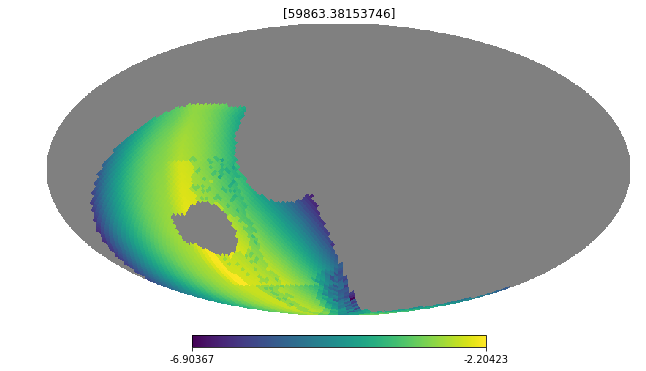

In [5]:
# Let's look at a reward function now
conditions = observatory.return_conditions()
reward = scheduler.survey_lists[2][1].calc_reward_function(conditions)
hp.mollview(reward, title=conditions.mjd)

In [4]:
# Now let's restore to a point about half way through
scheduler, observatory = gen_sched_obs()
scheduler, observatory = restore_scheduler(4100, scheduler, observatory, 'restore_example.db')

/Users/yoachim/git_repos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:373: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


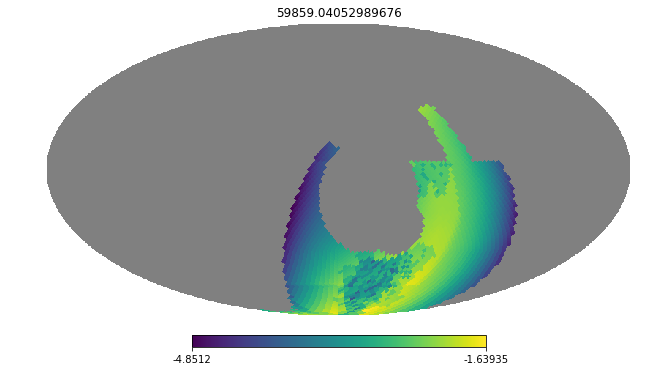

In [5]:
conditions = observatory.return_conditions()
reward = scheduler.survey_lists[2][1].calc_reward_function(conditions)
hp.mollview(reward, title=conditions.mjd)

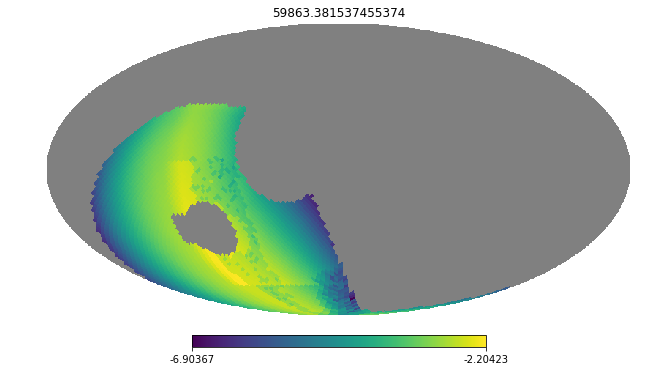

In [6]:
# Restore everything, so this should match the first plot
scheduler, observatory = gen_sched_obs()
scheduler, observatory = restore_scheduler(8310, scheduler, observatory, 'restore_example.db')

conditions = observatory.return_conditions()
reward = scheduler.survey_lists[2][1].calc_reward_function(conditions)
hp.mollview(reward, title=conditions.mjd)